# RMSD of predicted to solved structures
run prior to generating alignments in order to confirm fidelity of TCRDock predictions

### input file setup

In [7]:
# Generates input .tsv files to for setup.sh in /scripts 

import os
import pandas as pd

# === Constants ===
solved_meta_file = "/home/ggrama/tcrgen/compiled_solved_metadata.csv" # experimentally solved structure information
output_dir = "/scratch/ggrama/tcrgen/solved/user_targets" # write to scratch
organism = 'human'
mhc_class = 1
mhc = 'A*02:01'
required_cols = {'Peptide', 'TRAV', 'TRAJ', 'CDR3α', 'TRBV', 'TRBJ', 'CDR3β'}

# === Load solved metadata ===
solved_meta = pd.read_csv(solved_meta_file)
solved_meta = solved_meta.set_index("ID")
os.makedirs(output_dir, exist_ok=True)

# === Iterate through all entries ===
for solved_id, row in solved_meta.iterrows():
    if any(pd.isna(row[col]) or str(row[col]).strip() == "" for col in required_cols):
        print(f"Skipping {solved_id} — missing required fields")
        continue

    target = pd.DataFrame([dict(
        organism=organism,
        mhc_class=mhc_class,
        mhc=mhc,
        peptide=row['Peptide'],
        va=row['TRAV'],
        ja=row['TRAJ'],
        cdr3a=row['CDR3α'],
        vb=row['TRBV'],
        jb=row['TRBJ'],
        cdr3b=row['CDR3β']
    )])

    outpath = os.path.join(output_dir, f"{solved_id}.tsv")

    try:
        target.to_csv(outpath, sep="\t", index=False)
        print(f"Wrote: {outpath}")
    except Exception as e:
        print(f"Failed to write {outpath}: {e}")


Wrote: /scratch/ggrama/tcrgen/solved/user_targets/2vlj.tsv
Wrote: /scratch/ggrama/tcrgen/solved/user_targets/2vlk.tsv
Wrote: /scratch/ggrama/tcrgen/solved/user_targets/2vlr.tsv
Wrote: /scratch/ggrama/tcrgen/solved/user_targets/5isz.tsv
Wrote: /scratch/ggrama/tcrgen/solved/user_targets/1oga.tsv
Wrote: /scratch/ggrama/tcrgen/solved/user_targets/5euo.tsv


In [2]:
# writes .tsv paths to .txt file which will be read by setup.sh

from pathlib import Path

# === Config ===
ROOT_DIR = Path("/scratch/ggrama/tcrgen")
OUTPUT_FILE = Path("/home/ggrama/tcrgen/scripts/tsv_paths.txt") # input file in setup.sh, change path

# === Remove old output file if it exists
OUTPUT_FILE.unlink(missing_ok=True)

# === Search for all .tsv files under user_targets/
tsv_files = list(ROOT_DIR.rglob("*/user_targets/*.tsv"))
missing = []

for tsv_path in tsv_files:
    if ".ipynb_checkpoints" in str(tsv_path):
        continue

    basename = tsv_path.stem
    parent_dir = tsv_path.parent
    expected_targets_tsv = parent_dir.parent / "user_outputs" / basename / "targets.tsv"

    if not expected_targets_tsv.exists():
        missing.append(str(tsv_path))

# === Write missing paths to file
if missing:
    OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    with open(OUTPUT_FILE, "w") as f:
        f.write("\n".join(missing))
    print(f"❌ Missing targets.tsv files listed in: {OUTPUT_FILE}")
    print(f"Count: {len(missing)}")
else:
    print("✅ All user_outputs/…/targets.tsv files present.")

# sbatch scripts/setup.sh 

✅ All user_outputs/…/targets.tsv files present.


### TCRDock prediction setup

In [3]:
# writes targets.tsv paths to .txt file which will be read by predict.sh

from pathlib import Path

# === Config ===
ROOT_DIR = Path("/scratch/ggrama/tcrgen")
OUTPUT_FILE = Path("/home/ggrama/tcrgen/scripts/targets_paths.txt")

# === Remove old file if it exists ===
OUTPUT_FILE.unlink(missing_ok=True)

# === Locate all targets.tsv files ===
targets_files = list(ROOT_DIR.rglob("targets.tsv"))
missing = []

for targets_path in targets_files:
    if ".ipynb_checkpoints" in str(targets_path):
        continue

    user_outputs_dir = targets_path.parent
    target_name = user_outputs_dir.name.strip()
    base_dir = user_outputs_dir.parent.parent
    predictions_dir = base_dir / "predictions" / target_name

    if not any(predictions_dir.glob("*.pdb")):
        missing.append(targets_path)

# === Save missing targets.tsv paths ===
if missing:
    OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    with open(OUTPUT_FILE, "w") as f:
        for path in missing:
            f.write(str(path) + "\n")
    print(f"Missing .pdb count: {len(missing)}")
else:
    print("All prediction outputs present.")

#sbatch predict.sh

All prediction outputs present.


### inputs for relax.sh

In [4]:
from pathlib import Path
from collections import defaultdict

# === Constants ===
TCRGEN_ROOT = Path("/scratch/ggrama/tcrgen/solved")
OUTPUT_FILE = Path("/home/ggrama/tcrgen/scripts/pdb_paths.txt")

# === Step 1: Gather all predicted pdbs
predicted_pdbs = list(TCRGEN_ROOT.glob("**/predictions/*/*.pdb"))

# === Step 2: Gather all relaxed pdbs and create fast lookup
relaxed_pdbs = list(TCRGEN_ROOT.glob("**/relaxed/*.pdb"))
relaxed_stems = {p.stem for p in relaxed_pdbs}

# === Step 3: Match each predicted to relaxed
missing = []
dir_counts = defaultdict(int)

for pred_pdb in predicted_pdbs:
    if ".ipynb_checkpoints" in str(pred_pdb):
        continue

    pred_stem = pred_pdb.stem
    relaxed_stem = f"{pred_stem}_relaxed_0001"

    if relaxed_stem not in relaxed_stems:
        missing.append(str(pred_pdb))

        # Grouping by relative path to give per-context info
        try:
            relative_parent = pred_pdb.parent.parent.relative_to(TCRGEN_ROOT)
            dir_counts[str(relative_parent)] += 1
        except Exception:
            pass

# === Step 4: Save missing list
OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
with open(OUTPUT_FILE, "w") as f:
    f.write("\n".join(missing))

# === Final Reporting
if missing:
    print(f"❌ Missing relaxed .pdbs written to: {OUTPUT_FILE}")
    print(f"Total missing: {len(missing)}")
    print("\nBreakdown by prediction group directory:")
    for group_dir, count in sorted(dir_counts.items()):
        print(f"{group_dir}: {count}")
else:
    print("✅ All relaxed .pdbs are present.")

#sbatch relax.sh

✅ All relaxed .pdbs are present.


### RMSD calculations to full structure and cdr3b:epitope interface
contact determined by findings outlined in this 2016 paper (https://pmc.ncbi.nlm.nih.gov/articles/PMC4894841/)

In [25]:
# full structure RMSD

import numpy as np
import pandas as pd
from pathlib import Path
from Bio.PDB import PDBParser, PPBuilder
from Bio import pairwise2
from Bio.Align import substitution_matrices
from Bio.SVDSuperimposer import SVDSuperimposer

# === Config ===
solved_dir = Path("/scratch/ggrama/tcrgen/solved/ground_truth_pdbs") # write ground truth pdbs to a dir under solved/ (pull from rcsb)
predicted_dir = Path("/scratch/ggrama/tcrgen/solved/relaxed") # use relaxed structure
output_file = Path("groundtruth_rmsd.csv")

parser = PDBParser(QUIET=True)
ppb = PPBuilder()
matrix = substitution_matrices.load("BLOSUM62")

# === Extract CA coordinates and sequence from first valid chain ===
def get_ca_coords_and_seq(pdb_path):
    structure = parser.get_structure(pdb_path.stem, pdb_path)
    for model in structure:
        for chain in model:
            peptides = ppb.build_peptides(chain)
            if not peptides:
                continue
            seq = str(peptides[0].get_sequence())
            ca_coords = [
                residue["CA"].get_coord()
                for residue in chain
                if "CA" in residue
            ]
            return np.array(ca_coords), seq
    return None, ""

# === Align sequences and get matched CA coordinates ===
def extract_flexible_ca_coords(pred_coords, pred_seq, solved_coords, solved_seq):
    alignment = pairwise2.align.globalds(solved_seq, pred_seq, matrix, -10, -1, one_alignment_only=True)[0]
    aligned_solved = alignment.seqA
    aligned_pred = alignment.seqB

    matched_pred_coords = []
    matched_solved_coords = []

    pred_index = 0
    solved_index = 0

    for a_s, a_p in zip(aligned_solved, aligned_pred):
        if a_s != '-' and a_p != '-':
            matched_pred_coords.append(pred_coords[pred_index])
            matched_solved_coords.append(solved_coords[solved_index])
        if a_s != '-':
            solved_index += 1
        if a_p != '-':
            pred_index += 1

    return np.array(matched_pred_coords), np.array(matched_solved_coords)

# === Main loop ===
results = []
predicted_files = list(predicted_dir.glob("*.pdb"))
print(f"Found {len(predicted_files)} predicted structures")

for pred_path in predicted_files:
    stem = pred_path.stem
    if "_run" not in stem:
        print(f"⚠️ Skipping {stem}: no '_run' in filename")
        continue

    pdb_id = stem.split("_run")[0]
    solved_path = solved_dir / f"{pdb_id}.pdb"

    if not solved_path.exists():
        print(f"❌ Skipping {pdb_id}: no solved file found.")
        continue

    pred_coords, pred_seq = get_ca_coords_and_seq(pred_path)
    solved_coords, solved_seq = get_ca_coords_and_seq(solved_path)

    if pred_coords is None or solved_coords is None:
        print(f"❌ Skipping {pdb_id}: could not extract CA coordinates.")
        continue

    try:
        sub_pred_coords, sub_solved_coords = extract_flexible_ca_coords(
            pred_coords, pred_seq, solved_coords, solved_seq
        )

        if sub_pred_coords.shape != sub_solved_coords.shape or sub_pred_coords.shape[0] < 5:
            print(f"⚠️ Poor alignment for {pdb_id}: {sub_pred_coords.shape} vs {sub_solved_coords.shape}")
            continue

        sup = SVDSuperimposer()
        sup.set(sub_pred_coords, sub_solved_coords)
        sup.run()
        rmsd = sup.get_rms()

        results.append((pdb_id, pred_path.name, solved_path.name, sub_pred_coords.shape[0], rmsd))

    except Exception as e:
        print(f"❌ Error on {pdb_id}: {e}")

# === Save CSV ===
df = pd.DataFrame(results, columns=["pdb_id", "predicted_file", "solved_file", "aligned_residues", "ca_rmsd"])
df.to_csv(output_file, index=False)
print(f"✅ Flexible RMSD complete — saved to {output_file}")


/home/ggrama/.local/lib/python3.12/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Found 6 predicted structures
✅ Flexible RMSD complete — saved to groundtruth_rmsd.csv


In [26]:
df = pd.read_csv("groundtruth_rmsd.csv") #should be well under 2 Angstroms
df

,pdb_id,predicted_file,solved_file,aligned_residues,ca_rmsd
0,2vlk,2vlk_run_T00000_A0201_GILGFVFTL_0_model_1_mode...,2vlk.pdb,175,0.656152
1,5euo,5euo_run_T00000_A0201_GILGFVFTL_0_model_1_mode...,5euo.pdb,175,0.629052
2,2vlr,2vlr_run_T00000_A0201_GILGFVFTL_0_model_1_mode...,2vlr.pdb,175,0.970827
3,1oga,1oga_run_T00000_A0201_GILGFVFTL_0_model_1_mode...,1oga.pdb,175,0.603651
4,2vlj,2vlj_run_T00000_A0201_GILGFVFTL_0_model_1_mode...,2vlj.pdb,175,0.737704
5,5isz,5isz_run_T00000_A0201_GILGFVFTL_0_model_1_mode...,5isz.pdb,175,0.568861


In [49]:
# cdr3b:epitope interface RMSD

import pandas as pd
import numpy as np
from pathlib import Path
from Bio.PDB import PDBParser
from Bio.SVDSuperimposer import SVDSuperimposer
from Bio import pairwise2
from Bio.Align import substitution_matrices
from Bio.Data.IUPACData import protein_letters_3to1
import re

# === Config ===
RELAXED_DIR = Path("/scratch/ggrama/tcrgen/solved/relaxed")
SOLVED_DIR = Path("/scratch/ggrama/tcrgen/solved/ground_truth_pdbs")
USER_TARGETS_DIR = Path("/scratch/ggrama/tcrgen/solved/user_outputs") # pulls targets.tsv file to identify cdr3b and epitope sequences for calculations, used for both ground truth and predicted pair (since they are the same sequence)
OUTPUT = Path("/home/ggrama/tcrgen/solved_relaxed_cdr3b_epitope_rmsd.csv")
DIST_CUTOFF = 7.0 

parser = PDBParser(QUIET=True)
matrix = substitution_matrices.load("BLOSUM62")

def extract_pdb_id(filename):
    match = re.match(r"([0-9][a-zA-Z0-9]{3})", filename)
    return match.group(1).lower() if match else None

def load_coords_seq_resnums(pdb_path):
    structure = parser.get_structure(pdb_path.stem, pdb_path)
    for chain in structure.get_chains():
        coords, seq, resnums = [], [], []
        for residue in chain:
            if "CA" in residue:
                coords.append(residue["CA"].get_coord())
                resname = residue.resname.strip().capitalize()
                seq.append(protein_letters_3to1.get(resname, "X"))
                resnums.append(residue.get_id()[1])
        if coords:
            return np.array(coords), "".join(seq), resnums
    return None, None, None

def find_subseq_indices_aligned(seq, subseq):
    aln = pairwise2.align.globalds(subseq, seq, matrix, -10, -1, one_alignment_only=True)
    if not aln:
        return None
    aligned_sub, aligned_seq = aln[0].seqA, aln[0].seqB
    indices, seq_idx = [], 0
    for a_sub, a_seq in zip(aligned_sub, aligned_seq):
        if a_sub != "-" and a_seq != "-":
            indices.append(seq_idx)
        if a_seq != "-":
            seq_idx += 1
    return indices if len(indices) >= 3 else None

def get_contact_indices(coords1, coords2, cutoff=7.0):
    contacts = []
    for i, c1 in enumerate(coords1):
        for c2 in coords2:
            if np.linalg.norm(c1 - c2) <= cutoff:
                contacts.append(i)
                break
    return sorted(set(contacts))

def get_target_sequences(pdb_id):
    tsv = USER_TARGETS_DIR / pdb_id / "targets.tsv"
    if not tsv.exists():
        return None, None
    df = pd.read_csv(tsv, sep="\t")
    colmap = {col.lower(): col for col in df.columns}
    cdr3b_col = next((colmap[k] for k in colmap if "cdr3b" in k), None)
    pep_col = next((colmap[k] for k in colmap if "peptide" in k), None)
    if not cdr3b_col or not pep_col:
        return None, None
    cdr3b, peptide = df.at[0, cdr3b_col], df.at[0, pep_col]
    if pd.isna(cdr3b) or pd.isna(peptide):
        return None, None
    return str(cdr3b).strip(), str(peptide).strip()

# === Main
results = []

relaxed_files = sorted(RELAXED_DIR.glob("*_relaxed_0001.pdb"))
for relaxed_path in relaxed_files:
    pdb_id = extract_pdb_id(relaxed_path.name)
    if not pdb_id:
        continue

    solved_path = SOLVED_DIR / f"{pdb_id}.pdb"
    if not solved_path.exists():
        print(f"[ERROR] No solved structure for {pdb_id}")
        continue

    cdr3b, peptide = get_target_sequences(pdb_id)
    if not cdr3b or not peptide:
        print(f"[WARN] Skipping {pdb_id}: Missing CDR3b or peptide")
        continue

    pred_coords, pred_seq, pred_resnums = load_coords_seq_resnums(relaxed_path)
    solved_coords, solved_seq, solved_resnums = load_coords_seq_resnums(solved_path)

    if pred_coords is None or solved_coords is None:
        print(f"[WARN] {pdb_id}: Could not load coordinate data")
        continue

    idx_cdr3b_pred = find_subseq_indices_aligned(pred_seq, cdr3b)
    idx_pep_pred = find_subseq_indices_aligned(pred_seq, peptide)
    idx_cdr3b_solved = find_subseq_indices_aligned(solved_seq, cdr3b)
    idx_pep_solved = find_subseq_indices_aligned(solved_seq, peptide)

    if not idx_cdr3b_pred or not idx_pep_pred or not idx_cdr3b_solved or not idx_pep_solved:
        print(f"[WARN] Alignment failed for {pdb_id}")
        continue

    contact_solved = get_contact_indices(solved_coords[idx_cdr3b_solved], solved_coords[idx_pep_solved], DIST_CUTOFF)
    contact_residues_solved = set(solved_resnums[idx_cdr3b_solved[i]] for i in contact_solved)

    print(f"[DEBUG] {pdb_id}: solved contact residue numbers: {sorted(contact_residues_solved)}")

    aln = pairwise2.align.globalds(pred_seq, solved_seq, matrix, -10, -1, one_alignment_only=True)[0]
    aligned_pred, aligned_solved = aln.seqA, aln.seqB
    i_pred = i_solved = 0
    matched_pred, matched_solved = [], []

    for a_p, a_s in zip(aligned_pred, aligned_solved):
        if a_p != "-" and a_s != "-":
            r_pred = pred_resnums[i_pred]
            r_solved = solved_resnums[i_solved]
            if r_solved in contact_residues_solved:
                matched_pred.append(pred_coords[i_pred])
                matched_solved.append(solved_coords[i_solved])
        if a_p != "-": i_pred += 1
        if a_s != "-": i_solved += 1

    print(f"[DEBUG] {pdb_id}: matched {len(matched_pred)} residues in interface")

    if len(matched_pred) < 3:
        print(f"[WARN] {pdb_id}: Not enough matched interface residues ({len(matched_pred)})")
        continue

    sup = SVDSuperimposer()
    sup.set(np.array(matched_solved), np.array(matched_pred))
    sup.run()
    rmsd = sup.get_rms()

    results.append({
        "pdb_id": pdb_id,
        "relaxed_file": relaxed_path.name,
        "solved_file": solved_path.name,
        "interface_residues": len(matched_pred),
        "cdr3b_epitope_rmsd": rmsd
    })

    print(f"[OK] {pdb_id}: RMSD = {rmsd:.3f} A")

# Save output
df = pd.DataFrame(results)
df.to_csv(OUTPUT, index=False)
print(f"\n[DONE] Saved {len(results)} RMSDs to {OUTPUT}")


[DEBUG] 1oga: solved contact residue numbers: [1, 2, 3, 4, 5, 6]
[DEBUG] 1oga: matched 6 residues in interface
[OK] 1oga: RMSD = 0.250 A
[DEBUG] 2vlj: solved contact residue numbers: [1, 2, 3, 4, 5, 6]
[DEBUG] 2vlj: matched 6 residues in interface
[OK] 2vlj: RMSD = 0.253 A
[DEBUG] 2vlk: solved contact residue numbers: [1, 2, 3, 4, 5, 6]
[DEBUG] 2vlk: matched 6 residues in interface
[OK] 2vlk: RMSD = 0.306 A
[DEBUG] 2vlr: solved contact residue numbers: [1, 2, 3, 4, 5, 6]
[DEBUG] 2vlr: matched 6 residues in interface
[OK] 2vlr: RMSD = 0.348 A
[DEBUG] 5euo: solved contact residue numbers: [1, 2, 3, 4, 5, 6]
[DEBUG] 5euo: matched 6 residues in interface
[OK] 5euo: RMSD = 0.383 A
[DEBUG] 5isz: solved contact residue numbers: [1, 2, 3, 4, 5]
[DEBUG] 5isz: matched 5 residues in interface
[OK] 5isz: RMSD = 0.231 A

[DONE] Saved 6 RMSDs to /home/ggrama/tcrgen/solved_relaxed_cdr3b_epitope_rmsd.csv


# RMSD of generated sequences to experimental TCRs

## structure prediction using TCRDock

### Needleman-Wunsch + BLOSUM62 for cdr3b similarity
align generated cdr3b to ground truth cdr3b sequences to determine most compatible/similar structure for modelling

In [1]:
import pandas as pd
from pathlib import Path
from Bio.Align import PairwiseAligner, substitution_matrices

# === Setup aligner ===
aligner = PairwiseAligner()
aligner.mode = "global"
aligner.open_gap_score = -7        ## gap and extension penalty used by tcrdist
aligner.extend_gap_score = -1
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")

# === Load solved metadata ===
solved_metadata_path = Path("/home/ggrama/tcrgen/compiled_solved_metadata.csv")
solved_df = pd.read_csv(solved_metadata_path)

# === Base directory and exclusions ===
base_dir = Path("/scratch/ggrama/tcrgen")
exclude_substrings = ["temper_0.7", ".ipynb_checkpoints", "gen10", "in_sample"]

# === Loop through all relevant CSVs ===
for csv_path in base_dir.rglob("*.csv"):
    if csv_path.name == "needlemen.csv":
        continue  # Skip output files
    if any(excl in str(csv_path) for excl in exclude_substrings):
        continue  # Skip excluded paths

    try:
        gen_df = pd.read_csv(csv_path)
        if "tcr" not in gen_df.columns:
            print(f"Skipping {csv_path} (missing 'tcr' column)")
            continue

        results = []

        for idx, row in gen_df.iterrows():
            gen_seq = row["tcr"]
            if not isinstance(gen_seq, str) or not gen_seq:
                continue

            best_score = float("-inf")
            best_match_id = None
            best_match_seq = None

            for _, solved_row in solved_df.iterrows():
                try:
                    solved_seq = solved_row["CDR3β"]
                    score = aligner.score(gen_seq, solved_seq)
                    if score > best_score:
                        best_score = score
                        best_match_id = solved_row["PDB ID"]
                        best_match_seq = solved_seq
                except Exception as e:
                    print(f"Alignment error with {solved_row['PDB ID']}: {e}")
                    continue

            results.append({
                "Generated_Index": idx,
                "Generated_TCR": gen_seq,
                "Best_Solved_ID": best_match_id,
                "Best_Solved_TCR": best_match_seq,
                "Alignment_Score": best_score
            })

        if results:
            out_df = pd.DataFrame(results)
            output_path = csv_path.parent / "needlemen.csv"
            out_df.to_csv(output_path, index=False)
            print(f"Saved: {output_path}")

    except Exception as e:
        print(f"Error processing {csv_path}: {e}")


✅ Saved: /scratch/ggrama/tcrgen/gen5/fsp-oracle/needlemen.csv
✅ Saved: /scratch/ggrama/tcrgen/gen5/scp-select/needlemen.csv
✅ Saved: /scratch/ggrama/tcrgen/gen5/fsp-healthy/needlemen.csv
✅ Saved: /scratch/ggrama/tcrgen/gen5/fsp-fake/needlemen.csv
✅ Saved: /scratch/ggrama/tcrgen/gen5/scp-chain/needlemen.csv
✅ Saved: /scratch/ggrama/tcrgen/gen5/scp-random/needlemen.csv
✅ Saved: /scratch/ggrama/tcrgen/gen0/out_sample/temper_0.4/needlemen.csv
✅ Saved: /scratch/ggrama/tcrgen/controls/prior/needlemen.csv
✅ Saved: /scratch/ggrama/tcrgen/controls/gptll/needlemen.csv
✅ Saved: /scratch/ggrama/tcrgen/controls/random/needlemen.csv


### generating input files for tcrdock modelling
substitutes cdr3b sequence while leaving rest of input the same as most aligned ground truth

In [5]:
import os
import pandas as pd

# === Constants ===
solved_meta_file = "/home/ggrama/tcrgen/compiled_solved_metadata.csv"
root_dir = "/scratch/ggrama/tcrgen"
organism = 'human'
mhc_class = 1
mhc = 'A*02:01'
required_cols = {'Peptide', 'TRAV', 'TRAJ', 'CDR3α', 'TRBV', 'TRBJ', 'CDR3β'}

# === Load solved metadata once ===
solved_meta = pd.read_csv(solved_meta_file)
solved_meta = solved_meta.set_index("ID")

# === Helper function ===
def get_relative_id(input_path, root_dir="/scratch/ggrama/tcrgen"):
    """
    Returns a relative ID like 'gen5_fsp-oracle' or 'controls_prior' based on input path.
    """
    rel_path = os.path.relpath(input_path, root_dir)
    parts = rel_path.split(os.sep)

    if parts[0] in {"gen5", "gen10"}:
        return f"{parts[0]}_{parts[1]}"
    elif parts[0] == "controls":
        return f"controls_{parts[1]}"
    elif parts[0] == "gen0" and parts[1] in {"in_sample", "out_sample"}:
        return f"{parts[0]}_{parts[1]}_{parts[2]}"
    else:
        raise ValueError(f"Unrecognized path structure for: {input_path}")

# === Main loop ===
for dirpath, _, filenames in os.walk(root_dir):
    if ".ipynb_checkpoints" in dirpath:
        continue

    for fname in filenames:
        if fname == "needlemen.csv":
            input_path = os.path.join(dirpath, fname)

            try:
                base_id = get_relative_id(input_path, root_dir)
                matched = pd.read_csv(input_path)
            except Exception as e:
                print(f"Failed to load {input_path}: {e}")
                continue

            out_dir = os.path.join(dirpath, "user_targets")
            os.makedirs(out_dir, exist_ok=True)

            for i, row in matched.iterrows():
                gen_cdr3b = row.get("Generated_TCR") or row.get("Generated_CDR3b", "")
                solved_id = row["Best_Solved_ID"]

                if solved_id not in solved_meta.index:
                    print(f"Missing solved metadata for {solved_id}")
                    continue

                solved_row = solved_meta.loc[solved_id]

                if any(pd.isna(solved_row[col]) or str(solved_row[col]).strip() == "" for col in required_cols):
                    print(f"Skipping {solved_id} — missing required fields")
                    continue

                target = pd.DataFrame([dict(
                    organism=organism,
                    mhc_class=mhc_class,
                    mhc=mhc,
                    peptide=solved_row['Peptide'],
                    va=solved_row['TRAV'],
                    ja=solved_row['TRAJ'],
                    cdr3a=solved_row['CDR3α'],
                    vb=solved_row['TRBV'],
                    jb=solved_row['TRBJ'],
                    cdr3b=gen_cdr3b
                )])

                outname = f"{base_id}_{i}.tsv"
                outpath = os.path.join(out_dir, outname)

                try:
                    target.to_csv(outpath, sep="\t", index=False)
                    print(f"Wrote: {outpath}")
                except Exception as e:
                    print(f"Failed to write {outpath}: {e}")


Wrote: /scratch/ggrama/tcrgen/gen5/fsp-oracle/user_targets/gen5_fsp-oracle_0.tsv
Wrote: /scratch/ggrama/tcrgen/gen5/fsp-oracle/user_targets/gen5_fsp-oracle_1.tsv
Wrote: /scratch/ggrama/tcrgen/gen5/fsp-oracle/user_targets/gen5_fsp-oracle_2.tsv
Wrote: /scratch/ggrama/tcrgen/gen5/fsp-oracle/user_targets/gen5_fsp-oracle_3.tsv
Wrote: /scratch/ggrama/tcrgen/gen5/fsp-oracle/user_targets/gen5_fsp-oracle_4.tsv
Wrote: /scratch/ggrama/tcrgen/gen5/fsp-oracle/user_targets/gen5_fsp-oracle_5.tsv
Wrote: /scratch/ggrama/tcrgen/gen5/fsp-oracle/user_targets/gen5_fsp-oracle_6.tsv
Wrote: /scratch/ggrama/tcrgen/gen5/fsp-oracle/user_targets/gen5_fsp-oracle_7.tsv
Wrote: /scratch/ggrama/tcrgen/gen5/fsp-oracle/user_targets/gen5_fsp-oracle_8.tsv
Wrote: /scratch/ggrama/tcrgen/gen5/fsp-oracle/user_targets/gen5_fsp-oracle_9.tsv
Wrote: /scratch/ggrama/tcrgen/gen5/fsp-oracle/user_targets/gen5_fsp-oracle_10.tsv
Wrote: /scratch/ggrama/tcrgen/gen5/fsp-oracle/user_targets/gen5_fsp-oracle_11.tsv
Wrote: /scratch/ggrama/tcr

### inputs for setup.sh
writes paths to .txt, setup.sh found in scripts/ make sure to change array count

In [2]:
from pathlib import Path

# === Config ===
ROOT_DIR = Path("/scratch/ggrama/tcrgen")
OUTPUT_FILE = Path("/home/ggrama/tcrgen/scripts/tsv_paths.txt")

# === Remove old output file if it exists
OUTPUT_FILE.unlink(missing_ok=True)

# === Search for all .tsv files under user_targets/
tsv_files = list(ROOT_DIR.rglob("*/user_targets/*.tsv"))
missing = []

for tsv_path in tsv_files:
    if ".ipynb_checkpoints" in str(tsv_path):
        continue

    basename = tsv_path.stem
    parent_dir = tsv_path.parent
    expected_targets_tsv = parent_dir.parent / "user_outputs" / basename / "targets.tsv"

    if not expected_targets_tsv.exists():
        missing.append(str(tsv_path))

# === Write missing paths to file
if missing:
    OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    with open(OUTPUT_FILE, "w") as f:
        f.write("\n".join(missing))
    print(f"❌ Missing targets.tsv files listed in: {OUTPUT_FILE}")
    print(f"Count: {len(missing)}")
else:
    print("✅ All user_outputs/…/targets.tsv files present.")


✅ All user_outputs/…/targets.tsv files present.


### inputs for predict.sh
writes paths to .txt, ensure alphafold env is set up prior to running, check array count

In [3]:
from pathlib import Path

# === Config ===
ROOT_DIR = Path("/scratch/ggrama/tcrgen")
OUTPUT_FILE = Path("/home/ggrama/tcrgen/scripts/targets_paths.txt")

# === Remove old file if it exists ===
OUTPUT_FILE.unlink(missing_ok=True)

# === Locate all targets.tsv files ===
targets_files = list(ROOT_DIR.rglob("targets.tsv"))
missing = []

for targets_path in targets_files:
    if ".ipynb_checkpoints" in str(targets_path):
        continue

    user_outputs_dir = targets_path.parent
    target_name = user_outputs_dir.name.strip()
    base_dir = user_outputs_dir.parent.parent
    predictions_dir = base_dir / "predictions" / target_name

    if not any(predictions_dir.glob("*.pdb")):
        missing.append(targets_path)

# === Save missing targets.tsv paths ===
if missing:
    OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    with open(OUTPUT_FILE, "w") as f:
        for path in missing:
            f.write(str(path) + "\n")
    print(f"Missing .pdb count: {len(missing)}")
else:
    print("All prediction outputs present.")


All prediction outputs present.


### inputs for relax.sh
rinse and repeat, check array count

In [4]:
from pathlib import Path
from collections import defaultdict

# === Constants ===
TCRGEN_ROOT = Path("/scratch/ggrama/tcrgen")
OUTPUT_FILE = Path("/home/ggrama/tcrgen/scripts/pdb_paths.txt")

# === Step 1: Gather all predicted pdbs
predicted_pdbs = list(TCRGEN_ROOT.glob("**/predictions/*/*.pdb"))

# === Step 2: Gather all relaxed pdbs and create fast lookup
relaxed_pdbs = list(TCRGEN_ROOT.glob("**/relaxed/*.pdb"))
relaxed_stems = {p.stem for p in relaxed_pdbs}

# === Step 3: Match each predicted to relaxed
missing = []
dir_counts = defaultdict(int)

for pred_pdb in predicted_pdbs:
    if ".ipynb_checkpoints" in str(pred_pdb):
        continue

    pred_stem = pred_pdb.stem
    relaxed_stem = f"{pred_stem}_relaxed_0001"

    if relaxed_stem not in relaxed_stems:
        missing.append(str(pred_pdb))

        # Grouping by relative path to give per-context info
        try:
            relative_parent = pred_pdb.parent.parent.relative_to(TCRGEN_ROOT)
            dir_counts[str(relative_parent)] += 1
        except Exception:
            pass

# === Step 4: Save missing list
OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
with open(OUTPUT_FILE, "w") as f:
    f.write("\n".join(missing))

# === Final Reporting
if missing:
    print(f"❌ Missing relaxed .pdbs written to: {OUTPUT_FILE}")
    print(f"Total missing: {len(missing)}")
    print("\nBreakdown by prediction group directory:")
    for group_dir, count in sorted(dir_counts.items()):
        print(f"{group_dir}: {count}")
else:
    print("✅ All relaxed .pdbs are present.")


✅ All relaxed .pdbs are present.


## RMSD Calculation
use relaxed structures, cdr3b and epitope indicies are determined from .../user_outputs/{gen_idx}/targets.tsv

In [5]:
# will only update .csv, if precomputed rmsds are inaccurate, make sure to remove those entries otherwise calculations will not be updated

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from Bio.PDB import PDBParser
from Bio.SVDSuperimposer import SVDSuperimposer
from Bio.Align import PairwiseAligner
from Bio.Align.substitution_matrices import load
import os

# === Constants ===
SCRATCH_ROOT = Path("/scratch/ggrama/tcrgen")
GROUPED_ROOT = SCRATCH_ROOT / "solved/relaxed"
OUTPUT_CSV = Path("/home/ggrama/tcrgen/cdr3b_epitope_rmsd_flexible.csv")

# === Setup Parsers ===
parser = PDBParser(QUIET=True)
aligner = PairwiseAligner()
aligner.substitution_matrix = load("BLOSUM62")
aligner.open_gap_score = -7
aligner.extend_gap_score = -1
aligner.mode = "global"

# === Solved PDB Map ===
solved_pdbs = {
    p.name.split("_run")[0].lower(): p
    for p in GROUPED_ROOT.glob("*.pdb")
}

# === Helper: resolve CDR3β from targets.tsv ===
def get_cdr3b(tsv_path):
    if not tsv_path.exists():
        print(f"❌ Missing {tsv_path}")
        return None
    try:
        df = pd.read_csv(tsv_path, sep="\t")
        for col in df.columns:
            if "cdr3b" in col.lower():
                return str(df.loc[0, col])
        print(f"❌ No recognizable cdr3b column in {tsv_path.name}")
        return None
    except Exception as e:
        print(f"⚠️ Failed to read {tsv_path}: {e}")
        return None

# === Helper: get relative group identifier ===
def get_relative_id(input_path, root_dir="/scratch/ggrama/tcrgen"):
    rel_path = os.path.relpath(str(input_path), root_dir)
    parts = rel_path.split(os.sep)
    try:
        if parts[0] in {"gen5", "gen10"} and len(parts) > 1:
            return f"{parts[0]}_{parts[1]}"
        elif parts[0] == "controls" and len(parts) > 1:
            return f"controls_{parts[1]}"
        elif parts[0] == "gen0" and parts[1] in {"in_sample", "out_sample"} and len(parts) > 2:
            return f"{parts[0]}_{parts[1]}_{parts[2]}"
        else:
            return "unknown"
    except IndexError:
        return "unknown"

# === Load match CSVs ===
match_csvs = sorted([
    p for p in SCRATCH_ROOT.rglob("needlemen.csv")
    if ".ipynb_checkpoints" not in str(p)
])

# === Load existing RMSDs (if available) ===
if OUTPUT_CSV.exists():
    existing_df = pd.read_csv(OUTPUT_CSV)
    existing_set = set(existing_df["predicted_pdb"].tolist())
    print(f"🔁 Loaded {len(existing_set)} previously computed RMSDs")
else:
    existing_df = pd.DataFrame()
    existing_set = set()

results = []

for match_csv in match_csvs:
    match_dir = match_csv.parent
    group_id = get_relative_id(match_dir)

    try:
        df = pd.read_csv(match_csv)
    except Exception as e:
        print(f"❌ Failed to read {match_csv.name}: {e}")
        continue

    for _, row in df.iterrows():
        try:
            gen_idx = int(row["Generated_Index"])
        except Exception as e:
            print(f"❌ Invalid index: {row} — {e}")
            continue

        # === Resolve gen_id and paths ===
        relaxed_files = list((match_dir / "relaxed").glob(f"*_{gen_idx}_run*_relaxed_0001.pdb"))
        if not relaxed_files:
            print(f"❌ No relaxed PDB for index {gen_idx} in {match_dir}/relaxed")
            continue

        # e.g. controls_random_0_run_... → controls_random_0
        gen_id = relaxed_files[0].name.split("_run")[0]
        gen_folder = match_dir / "user_outputs" / gen_id
        tsv_path = gen_folder / "targets.tsv"

        if not tsv_path.exists():
            print(f"❌ Missing targets.tsv at {tsv_path}")
            continue

        print(f"✅ Index {gen_idx} → gen_id '{gen_id}' → {tsv_path}")

        pred_seq = get_cdr3b(tsv_path)
        solved_id = str(row["Best_Solved_ID"]).lower().strip()
        solved_tsv = SCRATCH_ROOT / "solved/user_outputs" / f"{solved_id}" / "targets.tsv"
        solved_seq = get_cdr3b(solved_tsv)

        if not pred_seq or not solved_seq:
            continue

        pred_relaxed_pdb = relaxed_files[0]
        solved_pdb = solved_pdbs.get(solved_id)
        if not solved_pdb or not solved_pdb.exists():
            print(f"❌ Missing solved structure for {solved_id}")
            continue

        # === Sequence alignment
        try:
            alignment = aligner.align(pred_seq, solved_seq)[0]
            pred_idx, solved_idx = [], []
            for (i1, i2), (j1, j2) in zip(*alignment.aligned):
                pred_idx.extend(range(i1, i2))
                solved_idx.extend(range(j1, j2))

            if len(pred_idx) != len(solved_idx):
                print(f"⚠️ Alignment mismatch: {gen_id}")
                continue

            pred_atoms = [a for a in list(parser.get_structure(gen_id, pred_relaxed_pdb).get_chains())[0].get_atoms() if a.get_id() == 'CA']
            solved_atoms = [a for a in list(parser.get_structure(solved_id, solved_pdb).get_chains())[0].get_atoms() if a.get_id() == 'CA']
            pred_coords = [pred_atoms[i].get_coord() for i in pred_idx if i < len(pred_atoms)]
            solved_coords = [solved_atoms[i].get_coord() for i in solved_idx if i < len(solved_atoms)]

            if len(pred_coords) != len(solved_coords) or not pred_coords:
                print(f"⚠️ Empty or mismatched coordinates for {gen_id}")
                continue

            sup = SVDSuperimposer()
            sup.set(np.array(solved_coords), np.array(pred_coords))
            sup.run()
            rmsd = sup.get_rms()

            if pred_relaxed_pdb.name in existing_set:
                print(f"⏭️ Skipping {pred_relaxed_pdb.name} — already computed")
                continue
            
            results.append({
                "predicted_pdb": pred_relaxed_pdb.name,
                "solved_id": solved_id,
                "group_dir": group_id,
                "rmsd_flexible": rmsd
            })

            print(f"✅ {gen_id} → RMSD: {rmsd:.3f} Å")

        except Exception as e:
            print(f"❌ Failed on {gen_id}: {e}")

# === Save results
if results:
    df_out = pd.DataFrame(results)
    df_out.to_csv(OUTPUT_CSV, index=False)
    print(f"\n🎉 Done. Saved {len(results)} RMSDs to: {OUTPUT_CSV}")
else:
    print("⚠️ No RMSDs computed.")


🔁 Loaded 300 previously computed RMSDs
✅ Index 0 → gen_id 'controls_gptll_0' → /scratch/ggrama/tcrgen/controls/gptll/user_outputs/controls_gptll_0/targets.tsv
⏭️ Skipping controls_gptll_0_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001.pdb — already computed
✅ Index 1 → gen_id 'controls_gptll_1' → /scratch/ggrama/tcrgen/controls/gptll/user_outputs/controls_gptll_1/targets.tsv
⏭️ Skipping controls_gptll_1_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001.pdb — already computed
✅ Index 2 → gen_id 'controls_gptll_2' → /scratch/ggrama/tcrgen/controls/gptll/user_outputs/controls_gptll_2/targets.tsv
⏭️ Skipping controls_gptll_2_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001.pdb — already computed
✅ Index 3 → gen_id 'controls_gptll_3' → /scratch/ggrama/tcrgen/controls/gptll/user_outputs/controls_gptll_3/targets.tsv
⏭️ Skipping controls_gptll_3_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001.pdb — already computed
✅ Index 4 → gen_id 'contr

/tmp/ipykernel_3308129/1610897963.py:21: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


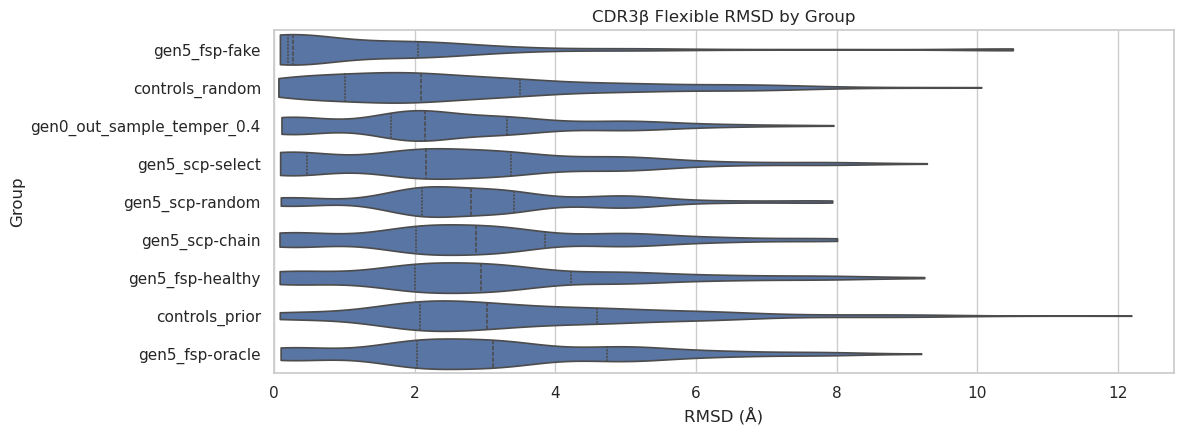

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Load and clean
df = pd.read_csv("/home/ggrama/tcrgen/cdr3b_epitope_rmsd_flexible.csv")
df = df[df["rmsd_flexible"] >= 0]  # just in case

# === Order groups by median RMSD
group_order = (
    df.groupby("group_dir")["rmsd_flexible"]
    .median()
    .sort_values()
    .index.tolist()
)

# === Plot
plt.figure(figsize=(12, len(group_order) * 0.5))
sns.set(style="whitegrid")

sns.violinplot(
    data=df,
    y="group_dir",
    x="rmsd_flexible",
    order=group_order,
    inner="quartile",
    scale="width",
    linewidth=1.2,
    cut=0  # prevents violin tails from extending past data
)

plt.title("CDR3β Flexible RMSD by Group")
plt.xlabel("RMSD (Å)")
plt.ylabel("Group")
plt.xlim(left=0)  # eliminate confusing negatives
plt.tight_layout()
plt.show()
